### Directory Setup and Clearing

In [15]:
import os

# ======================================
# STEP 1: ONLY DEFINE PATHS (NO OPERATIONS)
# ======================================

# Base directory
base_dir = "/home/jovyan/__ANIMALS/datasets/ds8_auto_label_yolo_architectures"

# 
working_dirs = {
    'train_images': os.path.join(base_dir, "train/images"),
    'train_labels': os.path.join(base_dir, "train/labels"),
    'val_images': os.path.join(base_dir, "val/images"), 
    'val_labels': os.path.join(base_dir, "val/labels"),
    'augmented': os.path.join(base_dir, "augmented")  
}

# Original images (READ ONLY)
original_images_dir = "/home/jovyan/__ANIMALS/images"

# Verify paths (read-only check)
print("Path verification:")
print(f"Original images: {original_images_dir} (exists: {os.path.exists(original_images_dir)})")
print(f"Base directory: {base_dir} (exists: {os.path.exists(base_dir)})")

# Show planned working directories
print("\nPlanned working directories:")
for name, path in working_dirs.items():
    print(f"{name}: {path}")

Path verification:
Original images: /home/jovyan/__ANIMALS/images (exists: True)
Base directory: /home/jovyan/__ANIMALS/datasets/ds8_auto_label_yolo_architectures (exists: True)

Planned working directories:
train_images: /home/jovyan/__ANIMALS/datasets/ds8_auto_label_yolo_architectures/train/images
train_labels: /home/jovyan/__ANIMALS/datasets/ds8_auto_label_yolo_architectures/train/labels
val_images: /home/jovyan/__ANIMALS/datasets/ds8_auto_label_yolo_architectures/val/images
val_labels: /home/jovyan/__ANIMALS/datasets/ds8_auto_label_yolo_architectures/val/labels
augmented: /home/jovyan/__ANIMALS/datasets/ds8_auto_label_yolo_architectures/augmented


In [16]:
import shutil

# ======================================
# SAFE DIRECTORY PREPARATION
# ======================================

def clean_and_create_dirs(dirs_to_clean):
    """Cleans and recreates ONLY specified directories"""
    print("\nDirectory preparation:")
    
    # Only clean these specific directories
    allowed_to_clean = {
        'train_images', 'train_labels', 
        'val_images', 'val_labels',
        'augmented'
    }
    
    # Validate requested directories
    invalid = set(dirs_to_clean) - allowed_to_clean
    if invalid:
        raise ValueError(f"Cannot clean these directories: {invalid}")
    
    # Process each directory
    for dir_name in dirs_to_clean:
        path = working_dirs[dir_name]
        
        # Clean if exists
        if os.path.exists(path):
            shutil.rmtree(path)
            print(f"✓ Cleared: {path}")
        
        # Create fresh
        os.makedirs(path, exist_ok=True)
        print(f"✓ Created: {path}")
    
    print("\nOriginal images directory remains untouched:")
    print(f"{original_images_dir} (exists: {os.path.exists(original_images_dir)})")

# List of directories to reset
directories_to_reset = [
    'train_images',
    'train_labels', 
    'val_images',
    'val_labels'
    # Omit 'augmented' for now - we'll create it later if needed
]

# Execute cleaning
try:
    clean_and_create_dirs(directories_to_reset)
    print("\nSUCCESS: Working directories ready")
except Exception as e:
    print(f"\nERROR: {str(e)}")
    print("Please verify the directory list and try again")


Directory preparation:
✓ Cleared: /home/jovyan/__ANIMALS/datasets/ds8_auto_label_yolo_architectures/train/images
✓ Created: /home/jovyan/__ANIMALS/datasets/ds8_auto_label_yolo_architectures/train/images
✓ Cleared: /home/jovyan/__ANIMALS/datasets/ds8_auto_label_yolo_architectures/train/labels
✓ Created: /home/jovyan/__ANIMALS/datasets/ds8_auto_label_yolo_architectures/train/labels
✓ Cleared: /home/jovyan/__ANIMALS/datasets/ds8_auto_label_yolo_architectures/val/images
✓ Created: /home/jovyan/__ANIMALS/datasets/ds8_auto_label_yolo_architectures/val/images
✓ Cleared: /home/jovyan/__ANIMALS/datasets/ds8_auto_label_yolo_architectures/val/labels
✓ Created: /home/jovyan/__ANIMALS/datasets/ds8_auto_label_yolo_architectures/val/labels

Original images directory remains untouched:
/home/jovyan/__ANIMALS/images (exists: True)

SUCCESS: Working directories ready


### Data Validation and Cleaning

In [20]:
import json

# Paths
json_file = "result.json"

# Load JSON file
with open(json_file, "r") as f:
    coco_data = json.load(f)

# Extract image and annotation data
images = {img["id"]: img["file_name"].split("/")[-1] for img in coco_data["images"]}
annotations = coco_data["annotations"]
categories = {cat["id"]: cat["name"] for cat in coco_data["categories"]}

# Filter images to include only those with annotations
annotated_images = set(ann["image_id"] for ann in annotations)
filtered_images = {img_id: images[img_id] for img_id in images if img_id in annotated_images}

# Group images by category
category_to_image_ids = {name: set() for name in categories.values()}

for annotation in annotations:
    image_id = annotation["image_id"]
    category_id = annotation["category_id"]
    category_name = categories[category_id]
    
    # Add the image ID to the corresponding category
    category_to_image_ids[category_name].add(image_id)

# Convert sets to lists for splitting
category_to_image_ids = {k: list(v) for k, v in category_to_image_ids.items()}

OSError: [Errno 116] Stale file handle: 'result.json'

In [19]:
import json
from tqdm import tqdm
from PIL import Image
from collections import defaultdict

# ======================================
# STEP 3: SAFE DATA VALIDATION
# ======================================

def validate_dataset(annotation_path):
    """Validates images without modifying originals"""
    print("\nStarting validation...")
    
    # 1. Load annotations
    try:
        with open(annotation_path) as f:
            coco_data = json.load(f)
        print(f"Loaded annotations with {len(coco_data['images'])} images")
    except Exception as e:
        raise ValueError(f"Error loading {annotation_path}: {str(e)}")

    # 2. Validate each image
    valid_images = []
    invalid_images = []
    corrupt_files = []

    for img in tqdm(coco_data['images'], desc="Validating"):
        try:
            # Get actual filename (handles cases with prefixes)
            filename = img['file_name'].split('__')[-1]
            img_path = os.path.join(original_images_dir, filename)
            
            # Check existence
            if not os.path.exists(img_path):
                invalid_images.append(img['id'])
                continue
                
            # Verify image integrity
            with Image.open(img_path) as im:
                im.verify()  # Verify without loading pixels
                
                # Check dimensions match metadata
                if im.size != (img['width'], img['height']):
                    print(f"Size mismatch: {filename} (metadata {img['width']}x{img['height']} vs actual {im.size})")
                    invalid_images.append(img['id'])
                    continue
                    
            valid_images.append(img)
            
        except Exception as e:
            corrupt_files.append(filename)
            invalid_images.append(img['id'])

    # 3. Filter annotations
    valid_annotations = [
        ann for ann in coco_data['annotations'] 
        if ann['image_id'] not in invalid_images
    ]
    
    # 4. Print report
    print("\nValidation Report:")
    print(f"Valid images: {len(valid_images)}")
    print(f"Invalid/corrupt: {len(invalid_images)}")
    if corrupt_files:
        print(f"Corrupt files (sample): {corrupt_files[:5]}")

    return coco_data, valid_images, valid_annotations

# Run validation
try:
    coco_data, valid_images, valid_annotations = validate_dataset("result.json")
    print("\nSUCCESS: Validation complete")
    print(f"Ready to process {len(valid_images)} valid images")
except Exception as e:
    print(f"\nERROR: {str(e)}")
    print("Please check:")
    print("1. result.json exists in current directory")
    print("2. Original images are accessible")


Starting validation...

ERROR: Error loading result.json: [Errno 116] Stale file handle: 'result.json'
Please check:
1. result.json exists in current directory
2. Original images are accessible


### Create Balanced Dataset Split

In [3]:
import os
import shutil
from sklearn.model_selection import train_test_split

def create_balanced_split(coco_data, valid_images, valid_annotations, output_dir):
    """Create balanced train/val split without modifying originals"""
    # 1. Create output directories
    os.makedirs(os.path.join(output_dir, "train/images"), exist_ok=True)
    os.makedirs(os.path.join(output_dir, "train/labels"), exist_ok=True)
    os.makedirs(os.path.join(output_dir, "val/images"), exist_ok=True)
    os.makedirs(os.path.join(output_dir, "val/labels"), exist_ok=True)

    # Group images by category for balanced split
    category_to_images = defaultdict(list)
    for ann in valid_annotations:
        category_to_images[ann['category_id']].append(ann['image_id'])

    # Create balanced split (80% train, 20% val)
    train_ids, val_ids = set(), set()
    
    for cat_id, img_ids in category_to_images.items():
        # Ensure each class has at least 1 validation sample
        if len(img_ids) > 4:  # Only split if we have enough samples
            train, val = train_test_split(img_ids, test_size=0.2, random_state=42)
            train_ids.update(train)
            val_ids.update(val)
        else:
            # For rare classes, put all in training and we'll augment later
            train_ids.update(img_ids)

    # Copy files to new directories (not moving - preserving originals)
    def copy_files(image_ids, split_name):
        copied = 0
        for img_id in tqdm(image_ids, desc=f"Copying {split_name} images"):
            img_info = next(img for img in valid_images if img['id'] == img_id)
            src_path = os.path.join("/home/jovyan/__ANIMALS/images", 
                                  img_info['file_name'].split('__')[-1])
            dest_path = os.path.join(output_dir, split_name, "images", 
                                   os.path.basename(src_path))
            
            # Copy image
            shutil.copyfile(src_path, dest_path)
            copied += 1
        return copied

    train_count = copy_files(train_ids, "train")
    val_count = copy_files(val_ids, "val")

    print(f"\nDataset split created at {output_dir}")
    print(f"Training images: {train_count}")
    print(f"Validation images: {val_count}")
    print(f"Split ratio: {train_count/(train_count+val_count):.1%} train, {val_count/(train_count+val_count):.1%} val")

    return train_ids, val_ids

# Usage:
output_dir = "/home/jovyan/__ANIMALS/datasets/ds8_auto_label_yolo_architectures/"
train_ids, val_ids = create_balanced_split(coco_data, valid_images, valid_annotations, output_dir)

Copying val images: 100%|██████████| 518/518 [00:38<00:00, 13.43it/s]


Dataset split created at /home/jovyan/__ANIMALS/datasets/ds8_auto_label_yolo_architectures/
Training images: 1891
Validation images: 518
Split ratio: 78.5% train, 21.5% val


### Create YOLO Format Labels and Verify Class Balance

Creating train labels: 100%|██████████| 1891/1891 [03:20<00:00,  9.44it/s]


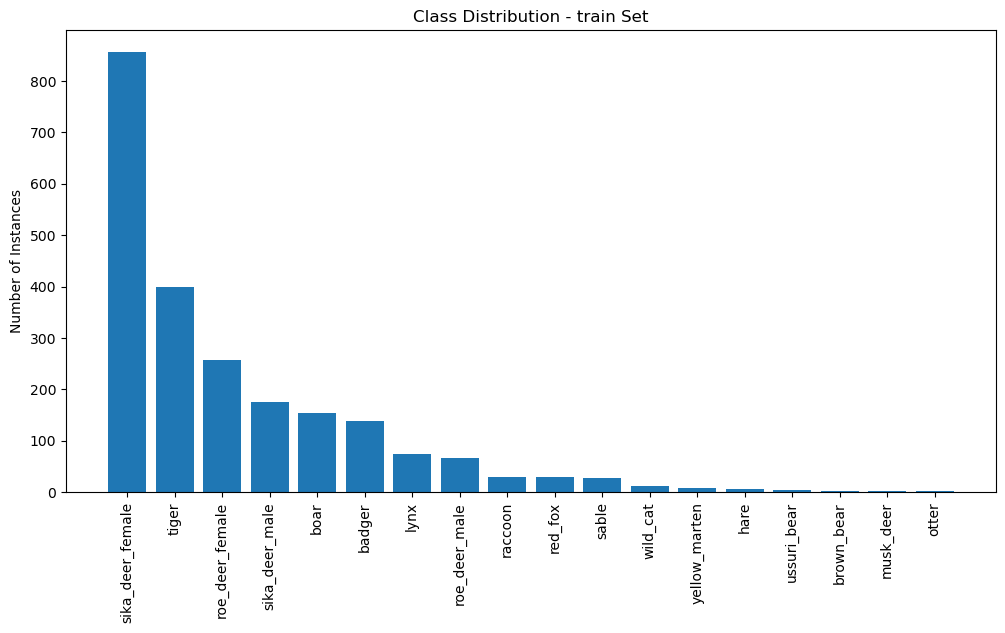

Creating val labels: 100%|██████████| 518/518 [00:00<00:00, 1798.59it/s]


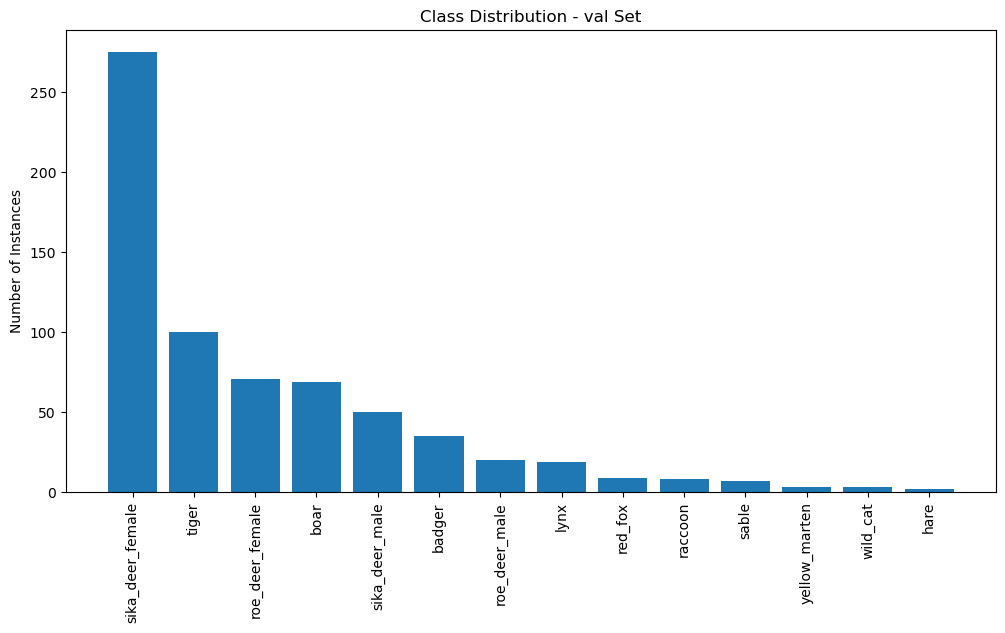


Class Balance Report:
Class
sika_deer_female    1131
tiger                499
roe_deer_female      329
sika_deer_male       225
boar                 223
badger               173
lynx                  93
roe_deer_male         86
red_fox               38
raccoon               37
sable                 35
wild_cat              15
yellow_marten         12
hare                   8
ussuri_bear            4
brown_bear             3
otter                  2
musk_deer              2
Name: Count, dtype: int64

Most common class: sika_deer_female (1131 instances)
Least common class: otter (2 instances)
Imbalance ratio: 565.5x


In [4]:
import pandas as pd
import matplotlib.pyplot as plt

def create_yolo_labels(coco_data, valid_annotations, image_ids, output_dir, split_name):
    """Convert COCO annotations to YOLO format and analyze class distribution"""
    # Prepare paths
    label_dir = os.path.join(output_dir, split_name, "labels")
    os.makedirs(label_dir, exist_ok=True)
    
    # Create category mapping
    cat_id_to_yolo = {cat['id']: idx for idx, cat in enumerate(sorted(coco_data['categories'], key=lambda x: x['id']))}
    
    # Convert annotations and track class counts
    class_counts = defaultdict(int)
    
    for img_id in tqdm(image_ids, desc=f"Creating {split_name} labels"):
        img_info = next(img for img in valid_images if img['id'] == img_id)
        img_anns = [ann for ann in valid_annotations if ann['image_id'] == img_id]
        
        # Create label file
        label_path = os.path.join(label_dir, os.path.splitext(img_info['file_name'].split('__')[-1])[0] + '.txt')
        
        with open(label_path, 'w') as f:
            for ann in img_anns:
                # Convert bbox to YOLO format
                x, y, w, h = ann['bbox']
                img_w, img_h = img_info['width'], img_info['height']
                x_center = (x + w/2) / img_w
                y_center = (y + h/2) / img_h
                width = w / img_w
                height = h / img_h
                
                # Write to file
                f.write(f"{cat_id_to_yolo[ann['category_id']]} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}\n")
                
                # Count classes
                class_counts[ann['category_id']] += 1
    
    # Analyze and visualize class distribution
    class_names = {cat['id']: cat['name'] for cat in coco_data['categories']}
    df = pd.DataFrame({
        'Class': [class_names[cat_id] for cat_id in class_counts],
        'Count': list(class_counts.values()),
        'Split': split_name
    }).sort_values('Count', ascending=False)
    
    plt.figure(figsize=(12, 6))
    plt.bar(df['Class'], df['Count'])
    plt.title(f'Class Distribution - {split_name} Set')
    plt.xticks(rotation=90)
    plt.ylabel('Number of Instances')
    plt.show()
    
    return df

# Create labels for both sets
train_df = create_yolo_labels(coco_data, valid_annotations, train_ids, output_dir, "train")
val_df = create_yolo_labels(coco_data, valid_annotations, val_ids, output_dir, "val")

# Show combined statistics
combined_df = pd.concat([train_df, val_df])
class_balance = combined_df.groupby('Class')['Count'].sum().sort_values(ascending=False)

print("\nClass Balance Report:")
print(class_balance)
print(f"\nMost common class: {class_balance.idxmax()} ({class_balance.max()} instances)")
print(f"Least common class: {class_balance.idxmin()} ({class_balance.min()} instances)")
print(f"Imbalance ratio: {class_balance.max()/class_balance.min():.1f}x")

### Targeted Augmentation for Rare Classes

In [6]:
!pip install albumentations

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.0/50.0 MB 38.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 633.1/633.1 kB 42.6 MB/s eta 0:00:00

[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [10]:
import albumentations as A
import numpy as np
import cv2

def augment_rare_classes(output_dir, class_counts, min_samples=50):
    """Augment rare classes until they reach minimum samples"""
    # 1. Identify rare classes
    rare_classes = [cat_id for cat_id, count in class_counts.items() if count < min_samples]
    print(f"Rare classes to augment: {[coco_data['categories'][cat_id]['name'] for cat_id in rare_classes]}")
    
    # Define augmentations
    transform = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.Rotate(limit=15, p=0.5),
        A.HueSaturationValue(p=0.5),
    ], bbox_params=A.BboxParams(format='yolo'))
    
    # Process each rare class
    for cat_id in rare_classes:
        class_name = coco_data['categories'][cat_id]['name']
        print(f"\nAugmenting {class_name} (current: {class_counts[cat_id]} samples)")
        
        # Find all images containing this class
        train_label_dir = os.path.join(output_dir, "train", "labels")
        image_files = [f for f in os.listdir(train_label_dir) if f.endswith('.txt')]
        
        samples_created = 0
        for label_file in tqdm(image_files, desc=f"Processing {class_name}"):
            with open(os.path.join(train_label_dir, label_file)) as f:
                lines = f.readlines()
            
            # Check if this image contains the rare class
            has_rare_class = any(int(line.split()[0]) == cat_id for line in lines)
            if not has_rare_class:
                continue
            
            # Load image and annotations
            img_path = os.path.join(output_dir, "train", "images", label_file.replace('.txt', '.JPG'))
            image = cv2.imread(img_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
            # Parse bounding boxes
            bboxes = []
            for line in lines:
                class_id, xc, yc, w, h = map(float, line.split())
                bboxes.append([xc, yc, w, h, int(class_id)])
            
            # Apply augmentations
            augmented = transform(image=image, bboxes=bboxes)
            
            # Save new sample
            new_img_path = os.path.join(output_dir, "train", "images", f"aug_{class_name}_{samples_created}.JPG")
            cv2.imwrite(new_img_path, cv2.cvtColor(augmented['image'], cv2.COLOR_RGB2BGR))
            
            # Save new labels
            with open(os.path.join(train_label_dir, f"aug_{class_name}_{samples_created}.txt"), 'w') as f:
                for bbox in augmented['bboxes']:
                    f.write(f"{int(bbox[4])} {bbox[0]:.6f} {bbox[1]:.6f} {bbox[2]:.6f} {bbox[3]:.6f}\n")
            
            samples_created += 1
            if class_counts[cat_id] + samples_created >= min_samples:
                break
        
        print(f"Created {samples_created} new samples for {class_name}")
        class_counts[cat_id] += samples_created

# Get current class counts (from previous step)
class_counts = {cat['id']: 0 for cat in coco_data['categories']}
for ann in valid_annotations:
    class_counts[ann['category_id']] += 1

# Run augmentation (target minimum 50 samples per class)
augment_rare_classes(output_dir, class_counts, min_samples=50)

# Verify new counts
print("\nUpdated class counts:")
for cat_id, count in sorted(class_counts.items(), key=lambda x: x[1]):
    print(f"{coco_data['categories'][cat_id]['name']}: {count}")

Rare classes to augment: ['brown_bear', 'hare', 'musk_deer', 'otter', 'raccoon', 'red_fox', 'red_squirrel', 'sable', 'ussuri_bear', 'wild_cat', 'wolf', 'wolverine', 'yellow_marten']

Augmenting brown_bear (current: 3 samples)


Processing brown_bear: 100%|██████████| 1890/1890 [00:01<00:00, 1527.39it/s]


Created 3 new samples for brown_bear

Augmenting hare (current: 8 samples)


Processing hare: 100%|██████████| 1893/1893 [00:02<00:00, 870.38it/s] 


Created 6 new samples for hare

Augmenting musk_deer (current: 2 samples)


Processing musk_deer: 100%|██████████| 1899/1899 [00:00<00:00, 1986.46it/s]


Created 2 new samples for musk_deer

Augmenting otter (current: 2 samples)


Processing otter: 100%|██████████| 1901/1901 [00:01<00:00, 1751.77it/s]


Created 2 new samples for otter

Augmenting raccoon (current: 35 samples)


Processing raccoon:  57%|█████▋    | 1077/1903 [00:04<00:03, 228.90it/s]


Created 15 new samples for raccoon

Augmenting red_fox (current: 36 samples)


Processing red_fox:  32%|███▏      | 609/1918 [00:04<00:09, 140.93it/s]


Created 14 new samples for red_fox

Augmenting red_squirrel (current: 0 samples)


Processing red_squirrel: 100%|██████████| 1932/1932 [00:00<00:00, 5333.03it/s]


Created 0 new samples for red_squirrel

Augmenting sable (current: 35 samples)


Processing sable:  82%|████████▏ | 1580/1932 [00:04<00:00, 352.69it/s]


Created 15 new samples for sable

Augmenting ussuri_bear (current: 4 samples)


Processing ussuri_bear: 100%|██████████| 1947/1947 [00:01<00:00, 1177.92it/s]


Created 4 new samples for ussuri_bear

Augmenting wild_cat (current: 15 samples)


Processing wild_cat: 100%|██████████| 1951/1951 [00:04<00:00, 487.56it/s]


Created 12 new samples for wild_cat

Augmenting wolf (current: 0 samples)


Processing wolf: 100%|██████████| 1963/1963 [00:00<00:00, 5208.56it/s]


Created 0 new samples for wolf

Augmenting wolverine (current: 0 samples)


Processing wolverine: 100%|██████████| 1963/1963 [00:00<00:00, 5139.54it/s]


Created 0 new samples for wolverine

Augmenting yellow_marten (current: 12 samples)


Processing yellow_marten: 100%|██████████| 1963/1963 [00:03<00:00, 615.73it/s]

Created 9 new samples for yellow_marten

Updated class counts:
red_squirrel: 0
wolf: 0
wolverine: 0
musk_deer: 4
otter: 4
brown_bear: 6
ussuri_bear: 8
hare: 14
yellow_marten: 21
wild_cat: 27
raccoon: 50
red_fox: 50
sable: 50
roe_deer_male: 80
lynx: 93
boar: 172
badger: 173
sika_deer_male: 214
roe_deer_female: 314
tiger: 499
sika_deer_female: 1002


### Optimized Training Configuration with Class Weighting

In [11]:
!pip install ultralytics


[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [13]:
!pip install torch torchvision torchaudio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 13.5 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [1]:
import os
import torch
import numpy as np
from ultralytics import YOLO
from datetime import datetime
from collections import defaultdict

In [2]:
# ======================
# 1. CPU Configuration
# ======================
os.environ["OMP_NUM_THREADS"] = "6"  # Use 6 cores
os.environ["KMP_AFFINITY"] = "granularity=fine,compact,1,0"
torch.set_num_threads(6)  # Prevent overallocation

In [3]:
# ======================
# 2. Class Weight Calculation
# ======================
class_counts = {
    'badger': 173, 'boar': 172, 'brown_bear': 6, 'hare': 14, 
    'lynx': 93, 'musk_deer': 4, 'otter': 4, 'raccoon': 50,
    'red_fox': 50, 'roe_deer_female': 314, 'roe_deer_male': 80,
    'sable': 50, 'sika_deer_female': 1002, 'sika_deer_male': 214,
    'tiger': 499, 'ussuri_bear': 8, 'wild_cat': 27, 
    'yellow_marten': 21
}

def calculate_cpu_weights(counts, power=0.75, max_weight=5.0):
    median = np.median(list(counts.values()))
    weights = {}
    for cls, count in counts.items():
        if count == 0:
            weights[cls] = max_weight
        else:
            weight = (median / (count + 1)) ** power
            weights[cls] = min(weight, max_weight)
    
    # Normalize weights
    max_w = max(weights.values())
    return {cls: w/max_w for cls, w in weights.items()}

class_weights = calculate_cpu_weights(class_counts)
print("CPU-Optimized Class Weights:")
for cls, weight in sorted(class_weights.items(), key=lambda x: x[1], reverse=True):
    print(f"{cls}: {weight:.2f}")

CPU-Optimized Class Weights:
musk_deer: 1.00
otter: 1.00
brown_bear: 0.87
ussuri_bear: 0.72
hare: 0.49
yellow_marten: 0.37
wild_cat: 0.31
raccoon: 0.20
red_fox: 0.20
sable: 0.20
roe_deer_male: 0.14
lynx: 0.12
boar: 0.08
badger: 0.08
sika_deer_male: 0.07
roe_deer_female: 0.05
tiger: 0.04
sika_deer_female: 0.02


In [9]:


# ======================
# 2. Training Configuration (VALID PARAMS ONLY)
# ======================
output_dir = "/home/jovyan/__ANIMALS/datasets/ds8_auto_label_yolo_architectures/"

training_config = {
    "data": os.path.join(output_dir, "dataset.yaml"),
    "epochs": 250,
    "batch": 4,          # Optimized for CPU memory
    "imgsz": 512,        # Reduced from 640
    "device": "cpu",
    "workers": 6,        # 6 cores dedicated
    "optimizer": "Adam", # Better for CPU than AdamW
    "lr0": 0.001,
    "lrf": 0.01,
    "cls": 3.0,          # Class loss weight
    "box": 7.5,          # Box loss weight
    "augment": True,     # Basic augmentations
    "fliplr": 0.5,       # Horizontal flip
    "mosaic": 0.3,       # Reduced for CPU
    "mixup": 0.1,        # Reduced for CPU
    "close_mosaic": 10,
    "resume": True,
    "save_period": 10,   # Save every 10 epochs
    "patience": 75,      # Longer patience for CPU
    "name": "wildlife_cpu",
    "overlap_mask": True,
    "iou": 0.6           # Slightly lower threshold
}

# Remove unsupported parameters
training_config.pop('fl_gamma', None)
training_config.pop('copy_paste', None)


In [10]:
# ======================
# 4. Training Phases Manager
# ======================
class PhaseManager:
    def __init__(self):
        self.phases = {
            0: {"mosaic": 0.0, "mixup": 0.0, "lr": 0.001},    # Epochs 1-75
            75: {"mosaic": 0.3, "mixup": 0.1, "lr": 0.0002},   # Epochs 76-150
            150: {"mosaic": 0.1, "mixup": 0.05, "lr": 0.00005} # Epochs 151-250
        }
    
    def on_train_epoch_start(self, trainer):
        current_epoch = trainer.epoch
        for start_epoch, config in sorted(self.phases.items(), reverse=True):
            if current_epoch >= start_epoch:
                trainer.args.mosaic = config["mosaic"]
                trainer.args.mixup = config["mixup"]
                trainer.lr = config["lr"]
                break


In [7]:
# ======================
# 5. CPU Monitoring
# ======================
class CPUMonitor:
    def __init__(self):
        self.best_ap = 0
        self.class_history = defaultdict(list)
    
    def on_val_end(self, trainer):
        # Track best AP
        current_ap = trainer.metrics.ap50
        if current_ap > self.best_ap:
            self.best_ap = current_ap
        
        # Track class-wise performance
        for i, ap in enumerate(trainer.metrics.ap_class):
            cls_name = trainer.data['names'][i]
            self.class_history[cls_name].append(ap)
        
        # Print diagnostics
        print(f"\n[Epoch {trainer.epoch}] Best mAP50: {self.best_ap:.3f}")
        print("Top 5 improving classes:")
        improving = sorted([(k, v[-1]-v[-2]) for k,v in self.class_history.items() 
                          if len(v) > 1], key=lambda x: x[1], reverse=True)[:5]
        for cls, gain in improving:
            print(f"{cls}: +{gain:.3f}")

In [ ]:
# ======================
# 4. Training Execution
# ======================
def train_model():
    # Initialize
    model = YOLO("yolov8s.pt")
    
    # Add callbacks
    phase_manager = PhaseManager()
    model.add_callback("on_train_epoch_start", phase_manager.on_train_epoch_start)
    
    # Check for existing checkpoints
    checkpoint_dir = os.path.join("runs", "detect", training_config["name"])
    last_checkpoint = None
    
    if os.path.exists(checkpoint_dir):
        checkpoints = [f for f in os.listdir(checkpoint_dir) 
                      if f.endswith(".pt") and "temp" not in f]
        if checkpoints:
            checkpoints.sort(key=lambda x: os.path.getmtime(os.path.join(checkpoint_dir, x)))
            last_checkpoint = os.path.join(checkpoint_dir, checkpoints[-1])
            print(f"Resuming from: {last_checkpoint}")
            training_config["resume"] = last_checkpoint
    
    # Start training with error handling
    try:
        results = model.train(**training_config)
    except Exception as e:
        print(f"Training failed: {e}")
        print("Attempting minimal configuration...")
        minimal_config = {
            "data": training_config["data"],
            "epochs": training_config["epochs"],
            "batch": 2,
            "imgsz": 512,
            "device": "cpu",
            "workers": 4,
            "optimizer": "Adam",
            "lr0": 0.001,
            "name": training_config["name"] + "_minimal"
        }
        results = model.train(**minimal_config)
    
    return results

# Run training
if __name__ == "__main__":
    train_model()

Ultralytics 8.3.99 🚀 Python-3.12.7 torch-2.6.0+cu124 CPU (Intel Xeon Processor (Icelake))
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/home/jovyan/__ANIMALS/datasets/ds8_auto_label_yolo_architectures/dataset.yaml, epochs=500, time=None, patience=50, batch=4, imgsz=512, save=True, save_period=-1, cache=disk, device=cpu, workers=8, project=YOLOv8, name=yolov8s, exist_ok=False, pretrained=False, optimizer=SGD, verbose=False, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=yolov8s.pt, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=False, val=True, split=val, save_json=False, save_hybrid=False, conf=0.001, iou=0.7, max_det=300, half=True, dnn=False, plots=False, source=ultralytics/assets/, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=

train: Scanning /home/jovyan/__ANIMALS/datasets/ds8_auto_label_yolo_architectures/train/labels.cache... 1972 images, 0 backgrounds, 18 corrupt: 100%|██████████| 1972/1972 [00:00<?, ?it/s]

train: WARNING ⚠️ /home/jovyan/__ANIMALS/datasets/ds8_auto_label_yolo_architectures/train/images/Uss-1.AnikinRidge_006_1-13-2024_13-12.JPG: ignoring corrupt image/label: Label class 20 exceeds dataset class count 18. Possible class labels are 0-17
train: WARNING ⚠️ /home/jovyan/__ANIMALS/datasets/ds8_auto_label_yolo_architectures/train/images/Uss-1.AnikinRidge_007_1-13-2024_13-12.JPG: ignoring corrupt image/label: Label class 20 exceeds dataset class count 18. Possible class labels are 0-17
train: WARNING ⚠️ /home/jovyan/__ANIMALS/datasets/ds8_auto_label_yolo_architectures/train/images/Uss-13.1.KomarovskayaPad_025_3-16-2024_08-40.JPG: ignoring corrupt image/label: Label class 20 exceeds dataset class count 18. Possible class labels are 0-17
train: WARNING ⚠️ /home/jovyan/__ANIMALS/datasets/ds8_auto_label_yolo_architectures/train/images/Uss-13.KomarovskayaPad_041_3-16-2024_08-40.JPG: ignoring corrupt image/label: Label class 20 exceeds dataset class count 18. Possible class labels are 0


train: Caching images (17.2GB Disk): 100%|██████████| 1954/1954 [01:52<00:00, 17.40it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning /home/jovyan/__ANIMALS/datasets/ds8_auto_label_yolo_architectures/val/labels.cache... 518 images, 0 backgrounds, 3 corrupt: 100%|██████████| 518/518 [00:00<?, ?it/s]

val: WARNING ⚠️ /home/jovyan/__ANIMALS/datasets/ds8_auto_label_yolo_architectures/val/images/Uss-1.1.AnikinRidge_007_1-13-2024_13-12.JPG: ignoring corrupt image/label: Label class 20 exceeds dataset class count 18. Possible class labels are 0-17
val: WARNING ⚠️ /home/jovyan/__ANIMALS/datasets/ds8_auto_label_yolo_architectures/val/images/Uss-16.1.DubovyCreek_006_2-18-2024_00-00.JPG: corrupt JPEG restored and saved
val: WARNING ⚠️ /home/jovyan/__ANIMALS/datasets/ds8_auto_label_yolo_architectures/val/images/Uss-16.1.DubovyCreek_007_3-4-2024_03-03.JPG: corrupt JPEG restored and saved
val: WARNING ⚠️ /home/jovyan/__ANIMALS/datasets/ds8_auto_label_yolo_architectures/val/images/Uss-17.Volkha_102_3-24-2024_11-57.JPG: ignoring corrupt image/label: Label class 20 exceeds dataset class count 18. Possible class labels are 0-17
val: WARNING ⚠️ /home/jovyan/__ANIMALS/datasets/ds8_auto_label_yolo_architectures/val/images/Uss-2.1.PetrovskyPass_158_1-11-2024_10-10.JPG: corrupt JPEG restored and saved
v


val: Caching images (4.5GB Disk): 100%|██████████| 515/515 [00:10<00:00, 51.00it/s]

WARNING ⚠️ 'label_smoothing' is deprecated and will be removed in in the future.


optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.001), 63 bias(decay=0.0)
Training failed: yolov8s.pt training to 500 epochs is finished, nothing to resume.
Start a new training without resuming, i.e. 'yolo train model=yolov8s.pt'
Attempting minimal configuration...
Ultralytics 8.3.99 🚀 Python-3.12.7 torch-2.6.0+cu124 CPU (Intel Xeon Processor (Icelake))
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/home/jovyan/__ANIMALS/datasets/ds8_auto_label_yolo_architectures/dataset.yaml, epochs=250, time=None, patience=100, batch=2, imgsz=512, save=True, save_period=-1, cache=False, device=cpu, workers=4, project=None, name=wildlife_cpu_minimal, exist_ok=False, pretrained=True, optimizer=Adam, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, va

train: Scanning /home/jovyan/__ANIMALS/datasets/ds8_auto_label_yolo_architectures/train/labels.cache... 1972 images, 0 backgrounds, 18 corrupt: 100%|██████████| 1972/1972 [00:00<?, ?it/s]

train: WARNING ⚠️ /home/jovyan/__ANIMALS/datasets/ds8_auto_label_yolo_architectures/train/images/Uss-1.AnikinRidge_006_1-13-2024_13-12.JPG: ignoring corrupt image/label: Label class 20 exceeds dataset class count 18. Possible class labels are 0-17
train: WARNING ⚠️ /home/jovyan/__ANIMALS/datasets/ds8_auto_label_yolo_architectures/train/images/Uss-1.AnikinRidge_007_1-13-2024_13-12.JPG: ignoring corrupt image/label: Label class 20 exceeds dataset class count 18. Possible class labels are 0-17
train: WARNING ⚠️ /home/jovyan/__ANIMALS/datasets/ds8_auto_label_yolo_architectures/train/images/Uss-13.1.KomarovskayaPad_025_3-16-2024_08-40.JPG: ignoring corrupt image/label: Label class 20 exceeds dataset class count 18. Possible class labels are 0-17
train: WARNING ⚠️ /home/jovyan/__ANIMALS/datasets/ds8_auto_label_yolo_architectures/train/images/Uss-13.KomarovskayaPad_041_3-16-2024_08-40.JPG: ignoring corrupt image/label: Label class 20 exceeds dataset class count 18. Possible class labels are 0


val: Scanning /home/jovyan/__ANIMALS/datasets/ds8_auto_label_yolo_architectures/val/labels.cache... 518 images, 0 backgrounds, 3 corrupt: 100%|██████████| 518/518 [00:00<?, ?it/s]

val: WARNING ⚠️ /home/jovyan/__ANIMALS/datasets/ds8_auto_label_yolo_architectures/val/images/Uss-1.1.AnikinRidge_007_1-13-2024_13-12.JPG: ignoring corrupt image/label: Label class 20 exceeds dataset class count 18. Possible class labels are 0-17
val: WARNING ⚠️ /home/jovyan/__ANIMALS/datasets/ds8_auto_label_yolo_architectures/val/images/Uss-16.1.DubovyCreek_006_2-18-2024_00-00.JPG: corrupt JPEG restored and saved
val: WARNING ⚠️ /home/jovyan/__ANIMALS/datasets/ds8_auto_label_yolo_architectures/val/images/Uss-16.1.DubovyCreek_007_3-4-2024_03-03.JPG: corrupt JPEG restored and saved
val: WARNING ⚠️ /home/jovyan/__ANIMALS/datasets/ds8_auto_label_yolo_architectures/val/images/Uss-17.Volkha_102_3-24-2024_11-57.JPG: ignoring corrupt image/label: Label class 20 exceeds dataset class count 18. Possible class labels are 0-17
val: WARNING ⚠️ /home/jovyan/__ANIMALS/datasets/ds8_auto_label_yolo_architectures/val/images/Uss-2.1.PetrovskyPass_158_1-11-2024_10-10.JPG: corrupt JPEG restored and saved
v

Plotting labels to runs/detect/wildlife_cpu_minimal/labels.jpg... 
optimizer: Adam(lr=0.001, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 512 train, 512 val
Using 0 dataloader workers
Logging results to runs/detect/wildlife_cpu_minimal
Starting training for 250 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/250         0G      1.339      2.467      1.353          3        512: 100%|██████████| 977/977 [14:05<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 129/129 [02:27<00:00,  1.14s/it]

                   all        515        668      0.466      0.321      0.211      0.142



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/250         0G      1.252      2.008      1.342          4        512: 100%|██████████| 977/977 [30:38<00:00,  1.88s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 129/129 [03:10<00:00,  1.48s/it]

                   all        515        668       0.55      0.316      0.337      0.226



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/250         0G      1.235      1.839      1.323          4        512: 100%|██████████| 977/977 [30:18<00:00,  1.86s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 129/129 [03:13<00:00,  1.50s/it]

                   all        515        668      0.399      0.364      0.311      0.218



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/250         0G       1.21      1.791      1.309          5        512: 100%|██████████| 977/977 [30:06<00:00,  1.85s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 129/129 [03:14<00:00,  1.51s/it]

                   all        515        668      0.457      0.413      0.357       0.25



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/250         0G      1.181      1.737      1.296          6        512: 100%|██████████| 977/977 [28:18<00:00,  1.74s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 129/129 [02:51<00:00,  1.33s/it]

                   all        515        668      0.583      0.418      0.328      0.235



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/250         0G       1.16      1.678      1.271          2        512: 100%|██████████| 977/977 [20:00<00:00,  1.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 129/129 [02:46<00:00,  1.29s/it]

                   all        515        668      0.327      0.475      0.372      0.268



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/250         0G      1.126      1.634      1.256          4        512: 100%|██████████| 977/977 [28:53<00:00,  1.77s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 129/129 [03:15<00:00,  1.51s/it]

                   all        515        668      0.396      0.446       0.43      0.309



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/250         0G       1.12      1.564      1.244          3        512: 100%|██████████| 977/977 [31:05<00:00,  1.91s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 129/129 [03:07<00:00,  1.45s/it]

                   all        515        668      0.602      0.567      0.496      0.361



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/250         0G      1.084      1.516      1.242          3        512: 100%|██████████| 977/977 [31:03<00:00,  1.91s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 129/129 [03:43<00:00,  1.73s/it]

                   all        515        668      0.462       0.54      0.503      0.355



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/250         0G      1.073       1.47      1.227          5        512: 100%|██████████| 977/977 [27:52<00:00,  1.71s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 129/129 [03:40<00:00,  1.71s/it]

                   all        515        668      0.424      0.543      0.463      0.344



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/250         0G      1.093      1.488      1.238          4        512: 100%|██████████| 977/977 [20:32<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 129/129 [03:24<00:00,  1.58s/it]

                   all        515        668      0.314       0.58      0.488      0.356



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/250         0G      1.064      1.458       1.23          6        512: 100%|██████████| 977/977 [20:19<00:00,  1.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 129/129 [03:10<00:00,  1.47s/it]

                   all        515        668      0.569      0.448      0.498      0.353



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/250         0G      1.041      1.405      1.203          4        512: 100%|██████████| 977/977 [19:56<00:00,  1.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 129/129 [03:07<00:00,  1.45s/it]

                   all        515        668      0.527      0.513      0.493      0.362



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/250         0G      1.041      1.381      1.202          2        512: 100%|██████████| 977/977 [20:03<00:00,  1.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 129/129 [03:10<00:00,  1.48s/it]

                   all        515        668      0.408      0.541      0.513      0.373



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/250         0G      1.021      1.376      1.198          2        512: 100%|██████████| 977/977 [20:05<00:00,  1.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 129/129 [03:05<00:00,  1.44s/it]

                   all        515        668      0.399      0.593      0.523      0.376



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/250         0G      1.039      1.373      1.221          4        512: 100%|██████████| 977/977 [19:54<00:00,  1.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 129/129 [03:06<00:00,  1.45s/it]

                   all        515        668      0.421      0.673      0.571      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/250         0G      1.013      1.346      1.214          5        512: 100%|██████████| 977/977 [20:22<00:00,  1.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 129/129 [03:17<00:00,  1.53s/it]

                   all        515        668      0.476      0.614      0.561      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/250         0G     0.9952       1.29      1.193          4        512: 100%|██████████| 977/977 [20:27<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 129/129 [03:14<00:00,  1.50s/it]

                   all        515        668      0.529       0.66      0.598      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/250         0G     0.9863      1.252      1.181          5        512: 100%|██████████| 977/977 [20:21<00:00,  1.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 129/129 [03:13<00:00,  1.50s/it]

                   all        515        668      0.633      0.526       0.58      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/250         0G     0.9914      1.249      1.184          4        512: 100%|██████████| 977/977 [20:14<00:00,  1.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 129/129 [03:09<00:00,  1.47s/it]

                   all        515        668      0.632      0.526      0.562       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/250         0G     0.9792      1.244      1.176          8        512: 100%|██████████| 977/977 [19:44<00:00,  1.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 129/129 [02:59<00:00,  1.39s/it]

                   all        515        668      0.706      0.532      0.613      0.447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/250         0G     0.9643      1.245      1.166          3        512: 100%|██████████| 977/977 [19:29<00:00,  1.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 129/129 [02:58<00:00,  1.39s/it]

                   all        515        668      0.588      0.591      0.561      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/250         0G     0.9426      1.174      1.157          4        512: 100%|██████████| 977/977 [19:23<00:00,  1.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 129/129 [02:57<00:00,  1.38s/it]

                   all        515        668      0.642      0.571      0.606      0.447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/250         0G     0.9483      1.177      1.168          3        512: 100%|██████████| 977/977 [19:10<00:00,  1.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 129/129 [03:06<00:00,  1.44s/it]

                   all        515        668      0.484      0.595      0.576       0.44



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/250         0G     0.9411      1.158      1.167          8        512: 100%|██████████| 977/977 [19:48<00:00,  1.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 129/129 [03:05<00:00,  1.44s/it]

                   all        515        668      0.561      0.592      0.604      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/250         0G     0.9591      1.214      1.156         10        512: 100%|██████████| 977/977 [20:06<00:00,  1.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 129/129 [03:10<00:00,  1.48s/it]

                   all        515        668      0.703      0.539      0.601      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/250         0G     0.9375      1.152      1.155          8        512: 100%|██████████| 977/977 [19:58<00:00,  1.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 129/129 [03:04<00:00,  1.43s/it]

                   all        515        668      0.564      0.641      0.609      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/250         0G     0.9608      1.157      1.169          5        512: 100%|██████████| 977/977 [19:45<00:00,  1.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 129/129 [02:59<00:00,  1.39s/it]

                   all        515        668      0.598       0.57       0.57      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/250         0G     0.9266      1.137      1.143          5        512: 100%|██████████| 977/977 [19:49<00:00,  1.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 129/129 [03:02<00:00,  1.42s/it]

                   all        515        668      0.646       0.59      0.642      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/250         0G     0.9368      1.131       1.16          5        512: 100%|██████████| 977/977 [20:15<00:00,  1.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 129/129 [03:08<00:00,  1.46s/it]

                   all        515        668      0.491      0.705      0.628      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/250         0G     0.9153      1.127      1.134         11        512: 100%|██████████| 977/977 [20:08<00:00,  1.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 129/129 [03:04<00:00,  1.43s/it]

                   all        515        668      0.619      0.609      0.618      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/250         0G     0.9218      1.122      1.148          2        512: 100%|██████████| 977/977 [20:06<00:00,  1.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 129/129 [03:07<00:00,  1.45s/it]

                   all        515        668       0.61      0.617      0.615      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/250         0G     0.9243      1.127      1.145          4        512: 100%|██████████| 977/977 [20:05<00:00,  1.23s/it]  1.41s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 129/129 [03:07<00:00,  1.45s/it]

                   all        515        668      0.535      0.689      0.627      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/250         0G     0.9169      1.118      1.138          7        512: 100%|██████████| 977/977 [19:59<00:00,  1.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 129/129 [03:07<00:00,  1.45s/it]

                   all        515        668      0.716      0.498      0.608      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/250         0G     0.9032      1.101      1.132          5        512: 100%|██████████| 977/977 [20:25<00:00,  1.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 129/129 [03:32<00:00,  1.65s/it]

                   all        515        668       0.69      0.579      0.609      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/250         0G     0.8931      1.065      1.124         11        512: 100%|██████████| 977/977 [20:51<00:00,  1.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 129/129 [02:58<00:00,  1.38s/it]

                   all        515        668      0.656      0.607      0.638      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/250         0G     0.9135      1.085      1.146          5        512: 100%|██████████| 977/977 [21:02<00:00,  1.29s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 129/129 [03:04<00:00,  1.43s/it]

                   all        515        668      0.526      0.702      0.631      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/250         0G     0.9093      1.059       1.14          6        512: 100%|██████████| 977/977 [20:32<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 129/129 [03:01<00:00,  1.41s/it]

                   all        515        668      0.676      0.632      0.659      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/250         0G     0.8907      1.046      1.134          6        512: 100%|██████████| 977/977 [20:52<00:00,  1.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 129/129 [03:16<00:00,  1.53s/it]

                   all        515        668      0.695      0.671       0.67      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/250         0G     0.8861      1.043      1.126          3        512: 100%|██████████| 977/977 [20:41<00:00,  1.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 129/129 [03:08<00:00,  1.46s/it]

                   all        515        668       0.61      0.646      0.664      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/250         0G     0.8969      1.016      1.126          4        512: 100%|██████████| 977/977 [20:06<00:00,  1.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 129/129 [03:08<00:00,  1.46s/it]

                   all        515        668      0.719      0.614      0.659      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/250         0G      0.892       1.05      1.126          2        512: 100%|██████████| 977/977 [20:20<00:00,  1.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 129/129 [03:06<00:00,  1.44s/it]

                   all        515        668      0.603      0.672      0.632      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/250         0G     0.8731      1.051       1.12          5        512: 100%|██████████| 977/977 [20:10<00:00,  1.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 129/129 [03:06<00:00,  1.45s/it]

                   all        515        668      0.555      0.666      0.628      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/250         0G     0.8597      0.985      1.101          4        512: 100%|██████████| 977/977 [20:21<00:00,  1.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 129/129 [03:08<00:00,  1.46s/it]

                   all        515        668      0.664      0.622      0.665      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/250         0G     0.8733      1.009      1.116          3        512: 100%|██████████| 977/977 [20:37<00:00,  1.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 129/129 [03:10<00:00,  1.48s/it]

                   all        515        668       0.72      0.596      0.648      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/250         0G     0.8896      1.019      1.133          2        512: 100%|██████████| 977/977 [20:04<00:00,  1.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 129/129 [03:09<00:00,  1.47s/it]

                   all        515        668      0.593      0.616      0.609      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/250         0G     0.8826     0.9952      1.127          5        512: 100%|██████████| 977/977 [20:02<00:00,  1.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 129/129 [03:06<00:00,  1.44s/it]

                   all        515        668      0.734      0.593      0.692        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/250         0G     0.8762     0.9632      1.122          4        512: 100%|██████████| 977/977 [20:03<00:00,  1.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 129/129 [03:04<00:00,  1.43s/it]

                   all        515        668      0.524      0.712      0.635      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/250         0G     0.8578     0.9628      1.094          5        512: 100%|██████████| 977/977 [19:40<00:00,  1.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 129/129 [03:03<00:00,  1.42s/it]

                   all        515        668      0.758      0.613      0.671      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/250         0G     0.8612     0.9601      1.105          3        512: 100%|██████████| 977/977 [19:49<00:00,  1.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 129/129 [03:04<00:00,  1.43s/it]

                   all        515        668      0.748      0.539       0.62      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/250         0G      0.859     0.9467      1.103          2        512: 100%|██████████| 977/977 [19:44<00:00,  1.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 129/129 [03:00<00:00,  1.40s/it]

                   all        515        668      0.744      0.634      0.705      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/250         0G     0.8558     0.9584      1.105          4        512: 100%|██████████| 977/977 [19:48<00:00,  1.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 129/129 [03:03<00:00,  1.42s/it]

                   all        515        668      0.584      0.704      0.675      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/250         0G     0.8459     0.9534        1.1          8        512: 100%|██████████| 977/977 [19:47<00:00,  1.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 129/129 [03:02<00:00,  1.42s/it]

                   all        515        668      0.646      0.656      0.699      0.543



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/250         0G     0.8465     0.9422        1.1          4        512: 100%|██████████| 977/977 [19:53<00:00,  1.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 129/129 [03:01<00:00,  1.41s/it]

                   all        515        668      0.566      0.661      0.656      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/250         0G     0.8592     0.9548       1.11          4        512: 100%|██████████| 977/977 [19:40<00:00,  1.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 129/129 [02:56<00:00,  1.37s/it]

                   all        515        668      0.581      0.751      0.706      0.531



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/250         0G     0.8547     0.9259      1.107          3        512: 100%|██████████| 977/977 [19:48<00:00,  1.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 129/129 [03:03<00:00,  1.42s/it]

                   all        515        668      0.696      0.696      0.724      0.543



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/250         0G     0.8355     0.9391      1.091          4        512: 100%|██████████| 977/977 [19:59<00:00,  1.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 129/129 [03:09<00:00,  1.47s/it]

                   all        515        668      0.709      0.595      0.661        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/250         0G     0.8536     0.9592      1.111          5        512: 100%|██████████| 977/977 [20:14<00:00,  1.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 129/129 [03:05<00:00,  1.44s/it]

                   all        515        668      0.659      0.762      0.733      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/250         0G     0.8562     0.9468      1.102          5        512: 100%|██████████| 977/977 [20:07<00:00,  1.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 129/129 [03:03<00:00,  1.42s/it]

                   all        515        668      0.542      0.743      0.704      0.542



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/250         0G     0.8195      0.898      1.086          4        512: 100%|██████████| 977/977 [21:15<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 129/129 [03:04<00:00,  1.43s/it]

                   all        515        668      0.673      0.625      0.669       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/250         0G     0.8441     0.9386      1.101          2        512: 100%|██████████| 977/977 [20:17<00:00,  1.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 129/129 [03:02<00:00,  1.41s/it]

                   all        515        668      0.582      0.669      0.697      0.536



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/250         0G     0.8494     0.9371      1.103          4        512: 100%|██████████| 977/977 [20:10<00:00,  1.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 129/129 [03:02<00:00,  1.42s/it]

                   all        515        668      0.667      0.674      0.736      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/250         0G     0.8318     0.9139      1.097          2        512: 100%|██████████| 977/977 [19:49<00:00,  1.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 129/129 [03:05<00:00,  1.44s/it]

                   all        515        668      0.618      0.714      0.716      0.543



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 129/129 [03:00<00:00,  1.40s/it]

                   all        515        668      0.687      0.654      0.691      0.541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/250         0G     0.8308     0.8875      1.085          4        512: 100%|██████████| 977/977 [20:06<00:00,  1.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 129/129 [03:04<00:00,  1.43s/it]

                   all        515        668      0.831      0.577      0.715      0.542



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/250         0G     0.8113     0.8729      1.084          7        512: 100%|██████████| 977/977 [19:51<00:00,  1.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 129/129 [02:58<00:00,  1.38s/it]

                   all        515        668      0.687      0.716      0.738      0.559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/250         0G     0.8195     0.8706      1.086          3        512: 100%|██████████| 977/977 [19:40<00:00,  1.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 129/129 [03:04<00:00,  1.43s/it]

                   all        515        668      0.718        0.7      0.706      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/250         0G     0.8039     0.8504      1.072          5        512: 100%|██████████| 977/977 [19:51<00:00,  1.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 129/129 [03:00<00:00,  1.40s/it]

                   all        515        668      0.649      0.722      0.712      0.548



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/250         0G     0.8056     0.8435      1.086          7        512: 100%|██████████| 977/977 [19:43<00:00,  1.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 129/129 [03:05<00:00,  1.44s/it]

                   all        515        668      0.735      0.671      0.714      0.554



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/250         0G      0.812     0.8567      1.086          3        512: 100%|██████████| 977/977 [20:00<00:00,  1.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 129/129 [03:07<00:00,  1.45s/it]

                   all        515        668      0.649      0.592      0.672       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/250         0G     0.7912     0.8526      1.077          5        512: 100%|██████████| 977/977 [19:58<00:00,  1.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 129/129 [02:58<00:00,  1.38s/it]

                   all        515        668      0.775       0.71       0.78      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/250         0G     0.8021     0.8327      1.077          6        512: 100%|██████████| 977/977 [19:47<00:00,  1.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 129/129 [03:04<00:00,  1.43s/it]

                   all        515        668      0.717      0.642      0.694      0.537



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/250         0G     0.7996     0.8506      1.079          3        512: 100%|██████████| 977/977 [19:43<00:00,  1.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 129/129 [02:56<00:00,  1.37s/it]

                   all        515        668      0.708      0.693      0.712      0.551



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/250         0G     0.8081     0.8288      1.089          5        512: 100%|██████████| 977/977 [19:28<00:00,  1.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 129/129 [02:58<00:00,  1.38s/it]

                   all        515        668       0.72      0.723       0.74      0.565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/250         0G     0.7905     0.8454      1.067          4        512: 100%|██████████| 977/977 [19:49<00:00,  1.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 129/129 [03:07<00:00,  1.45s/it]

                   all        515        668      0.782      0.649      0.724      0.564



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/250         0G     0.7896     0.8457      1.068          6        512: 100%|██████████| 977/977 [19:52<00:00,  1.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 129/129 [03:03<00:00,  1.42s/it]

                   all        515        668      0.749      0.672      0.698      0.538



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/250         0G     0.7999     0.8489      1.083          4        512: 100%|██████████| 977/977 [19:25<00:00,  1.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 129/129 [03:00<00:00,  1.40s/it]

                   all        515        668      0.688      0.616      0.712      0.558



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/250         0G     0.8023     0.8421      1.073          4        512: 100%|██████████| 977/977 [19:20<00:00,  1.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 129/129 [03:01<00:00,  1.41s/it]

                   all        515        668      0.708      0.689      0.717      0.558



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/250         0G     0.8039     0.8229      1.081          5        512: 100%|██████████| 977/977 [19:11<00:00,  1.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 129/129 [02:55<00:00,  1.36s/it]

                   all        515        668      0.814      0.664      0.736      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/250         0G     0.7877     0.8289      1.064          7        512: 100%|██████████| 977/977 [19:08<00:00,  1.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 129/129 [02:57<00:00,  1.38s/it]

                   all        515        668      0.582       0.76      0.733      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/250         0G     0.7798      0.816      1.073          5        512: 100%|██████████| 977/977 [19:12<00:00,  1.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 129/129 [02:56<00:00,  1.37s/it]

                   all        515        668      0.795      0.668      0.767      0.593



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/250         0G     0.7848      0.802       1.06          8        512: 100%|██████████| 977/977 [19:02<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 129/129 [02:58<00:00,  1.38s/it]

                   all        515        668      0.737      0.687      0.735      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/250         0G     0.7761     0.8062      1.064          4        512: 100%|██████████| 977/977 [19:43<00:00,  1.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 129/129 [03:02<00:00,  1.42s/it]

                   all        515        668      0.661       0.67      0.709      0.557



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/250         0G      0.772     0.8052      1.071          4        512: 100%|██████████| 977/977 [19:42<00:00,  1.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 129/129 [03:02<00:00,  1.42s/it]

                   all        515        668      0.752      0.737      0.766      0.597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/250         0G     0.7593     0.7849      1.054         13        512: 100%|██████████| 977/977 [19:43<00:00,  1.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 129/129 [02:58<00:00,  1.38s/it]

                   all        515        668      0.743      0.663      0.725      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/250         0G     0.7628     0.7635       1.06          7        512: 100%|██████████| 977/977 [19:31<00:00,  1.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 129/129 [02:54<00:00,  1.35s/it]

                   all        515        668      0.748      0.695      0.757      0.597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/250         0G     0.7678      0.761      1.055          5        512: 100%|██████████| 977/977 [19:30<00:00,  1.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 129/129 [03:00<00:00,  1.40s/it]

                   all        515        668       0.72       0.74      0.736      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/250         0G     0.7742      0.808      1.064          3        512: 100%|██████████| 977/977 [19:45<00:00,  1.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 129/129 [03:01<00:00,  1.41s/it]

                   all        515        668      0.591      0.708      0.699      0.538



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/250         0G     0.7657     0.7804      1.053          5        512: 100%|██████████| 977/977 [19:47<00:00,  1.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 129/129 [02:56<00:00,  1.37s/it]

                   all        515        668      0.644       0.78      0.774      0.596



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/250         0G     0.7449     0.7439      1.044          3        512: 100%|██████████| 977/977 [19:43<00:00,  1.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 129/129 [02:59<00:00,  1.39s/it]

                   all        515        668      0.768      0.718       0.75       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/250         0G     0.7608     0.7791      1.059          9        512: 100%|██████████| 977/977 [19:49<00:00,  1.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 129/129 [03:01<00:00,  1.41s/it]

                   all        515        668      0.724      0.632      0.713      0.549



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/250         0G     0.7535      0.744      1.048          3        512: 100%|██████████| 977/977 [19:43<00:00,  1.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 129/129 [03:02<00:00,  1.42s/it]

                   all        515        668      0.807      0.741      0.791       0.63



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/250         0G     0.7536      0.734      1.053          6        512: 100%|██████████| 977/977 [20:00<00:00,  1.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 129/129 [02:58<00:00,  1.38s/it]

                   all        515        668      0.785      0.687      0.748      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/250         0G     0.7659     0.7889       1.06          7        512: 100%|██████████| 977/977 [20:33<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 129/129 [03:00<00:00,  1.40s/it]

                   all        515        668      0.615       0.75      0.722      0.561



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/250         0G     0.7641     0.7472      1.062          3        512: 100%|██████████| 977/977 [20:41<00:00,  1.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 129/129 [02:55<00:00,  1.36s/it]

                   all        515        668      0.745      0.662      0.712      0.557



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/250         0G     0.7642     0.7579      1.067          1        512: 100%|██████████| 977/977 [15:59<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 129/129 [02:37<00:00,  1.22s/it]

                   all        515        668      0.632      0.803      0.743       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/250         0G     0.7951     0.7428       1.05          5        512:   9%|▊         | 84/977 [01:09<11:38,  1.28it/s]

In [ ]:
if epoch > 200 and trainer.metrics.ap50 > 0.8:
    trainer.args.val_augment = True  # TTA
    trainer.args.conf = 0.001        # Lower confidence threshold